In [4]:
import numpy as np
from numpy import zeros, diag, eye, log, pi, sqrt, vstack, exp, mean, load
from numpy.linalg import solve
from scipy.stats import multivariate_normal as MVN
from tangential_hug_functions import Hug, HugTangential, Hop, run_hug_hop, run_thug_hop, HugStepEJSD, HugTangentialStepEJSD
from utils import ESS, quick_MVN_scatter, prep_contour, quick_MVN_marginals, MVN_scatters
import matplotlib.pyplot as plt
from scipy.stats import norm as ndist
from numpy.random import uniform, normal
from scipy.special import gammaincc
from scipy.special import gamma, erf
import tensorflow_probability as tfp
from scipy.optimize import root
from utils import ESS_univariate, box_plot
from IPython.display import display, Latex
from utils import ESS_univariate, ESS
from tangential_hug_functions import HugTangentialAR, compare_HUG_THUG_THUGAR

In [5]:
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log((abs(target.logpdf(xi) - z0) <= epsilon).astype('float64'))
    
def logprior_uniform(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all().astype('float64'))

def logprior_uniform_all(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all(axis=1).astype('float64'))
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform(xi) + log_uniform_kernel(xi, epsilon)

def log_abc_posterior_all(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform_all(xi) + log_uniform_kernel(xi, epsilon)
    
def grad_log_simulator(xi):
    """Gradient of log simulator N(mu, Sigma)."""
    return - solve(Sigma, xi)

# Prelim

In [58]:
# Target distribution is a diagonal MVN
Sigma0 = diag([1.0, 5.0])
rho = 1.0
Sigma = rho * Sigma0
target = MVN(zeros(2), Sigma)

# Initial point on z0-contour
x0 = normal(size=2)                           # Keep initial point the same
z0 = target.logpdf(x0)                        # Feed through simulator

# Proposal for velocity in HUG/THUG
q = MVN(zeros(2), eye(2))

In [59]:
N = 20000
epsilon = 0.000001
alpha = 0.999
prob = 0.9
T = 2.0
B = 5

In [60]:
hug_only, thug_only, thug_ar, ahug_only, athug_only, athug_ar = compare_HUG_THUG_THUGAR(x0, T, B, N, alpha, prob, 
                                                                                        q, log_abc_posterior, 
                                                                                        grad_log_simulator)

In [63]:
xlims = [-1.4, 1.4]
ylims = [-3.0, 3.0]

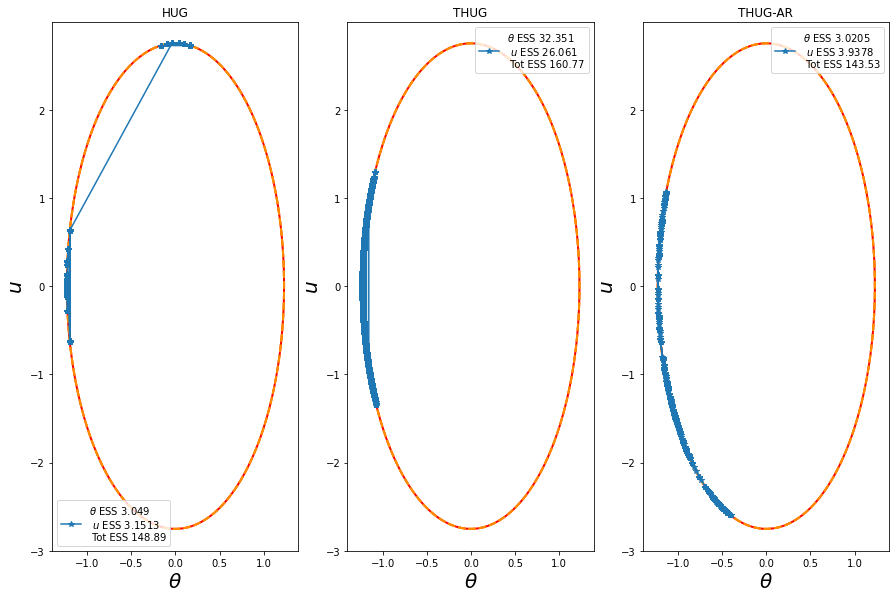

In [64]:
kkk = N
fig, ax = plt.subplots(ncols=3, figsize=(15, 10))
label = '$\\theta$ ESS {:.5}\n $u$ ESS {:.5}\n Tot ESS {:.5}'.format(
    ESS_univariate(hug_only[:kkk, 0]),
    ESS_univariate(hug_only[:kkk, 1]),
    ESS(hug_only[:kkk]))
ax[0].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[0].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[0].plot(*hug_only[:kkk].T, label=label, marker='*')
ax[0].legend()
ax[0].set_aspect("equal")
ax[0].set_xlabel("$\\theta$", fontsize=20)
ax[0].set_ylabel("$u$", fontsize=20)
ax[0].set_title("HUG")

label = '$\\theta$ ESS {:.5}\n $u$ ESS {:.5}\n Tot ESS {:.5}'.format(
    ESS_univariate(thug_only[:kkk, 0]),
    ESS_univariate(thug_only[:kkk, 1]),
    ESS(thug_only[:kkk]))
ax[1].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[1].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[1].plot(*thug_only[:kkk].T, label=label, marker="*")
ax[1].legend()
ax[1].set_aspect("equal")
ax[1].set_xlabel("$\\theta$", fontsize=20)
ax[1].set_ylabel("$u$", fontsize=20)
ax[1].set_title("THUG")

label = '$\\theta$ ESS {:.5}\n $u$ ESS {:.5}\n Tot ESS {:.5}'.format(
    ESS_univariate(thug_ar[:kkk, 0]),
    ESS_univariate(thug_ar[:kkk, 1]),
    ESS(thug_ar[:kkk]))
ax[2].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[2].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[2].plot(*thug_ar[:kkk].T, label=label, marker="*")
ax[2].legend()
ax[2].set_aspect("equal")
ax[2].set_xlabel("$\\theta$", fontsize=20)
ax[2].set_ylabel("$u$", fontsize=20)
ax[2].set_title("THUG-AR")

plt.show()

[-0.4055607053349849, -2.5975881937780674]

array([0.40556071, 0.51951764])

3.141592653589793

In [65]:
ESS_univariate(hug_only[:, 0]) / np.unique(hug_only, axis=0).shape[0]

0.035870748659501454

In [66]:
ESS_univariate(thug_only[:, 0]) / np.unique(thug_only, axis=0).shape[0]

0.019022235578418645

In [67]:
ESS_univariate(thug_ar[:, 0]) / np.unique(thug_ar, axis=0).shape[0]

0.008755077797217244

# Experiment

In [20]:
folder = "experiment14/"
THETA_ESS_THUG = load(folder + "THETA_ESS_THUG.npy")
U_ESS_THUG     = load(folder + "U_ESS_THUG.npy")
ESS_THUG       = load(folder + "ESS_THUG.npy")
A_THUG         = load(folder + "A_THUG.npy")

THETA_ESS_THUG_AR = load(folder + "THETA_ESS_THUG_AR.npy")
U_ESS_THUG_AR     = load(folder + "U_ESS_THUG_AR.npy")
ESS_THUG_AR       = load(folder + "ESS_THUG_AR.npy")
A_THUG_AR         = load(folder + "A_THUG_AR.npy")

PROBS    = load(folder + "PROBS.npy")
EPSILONS = load(folder + "EPSILONS.npy")

ValueError: List of boxplot statistics and `positions` values must have same the length

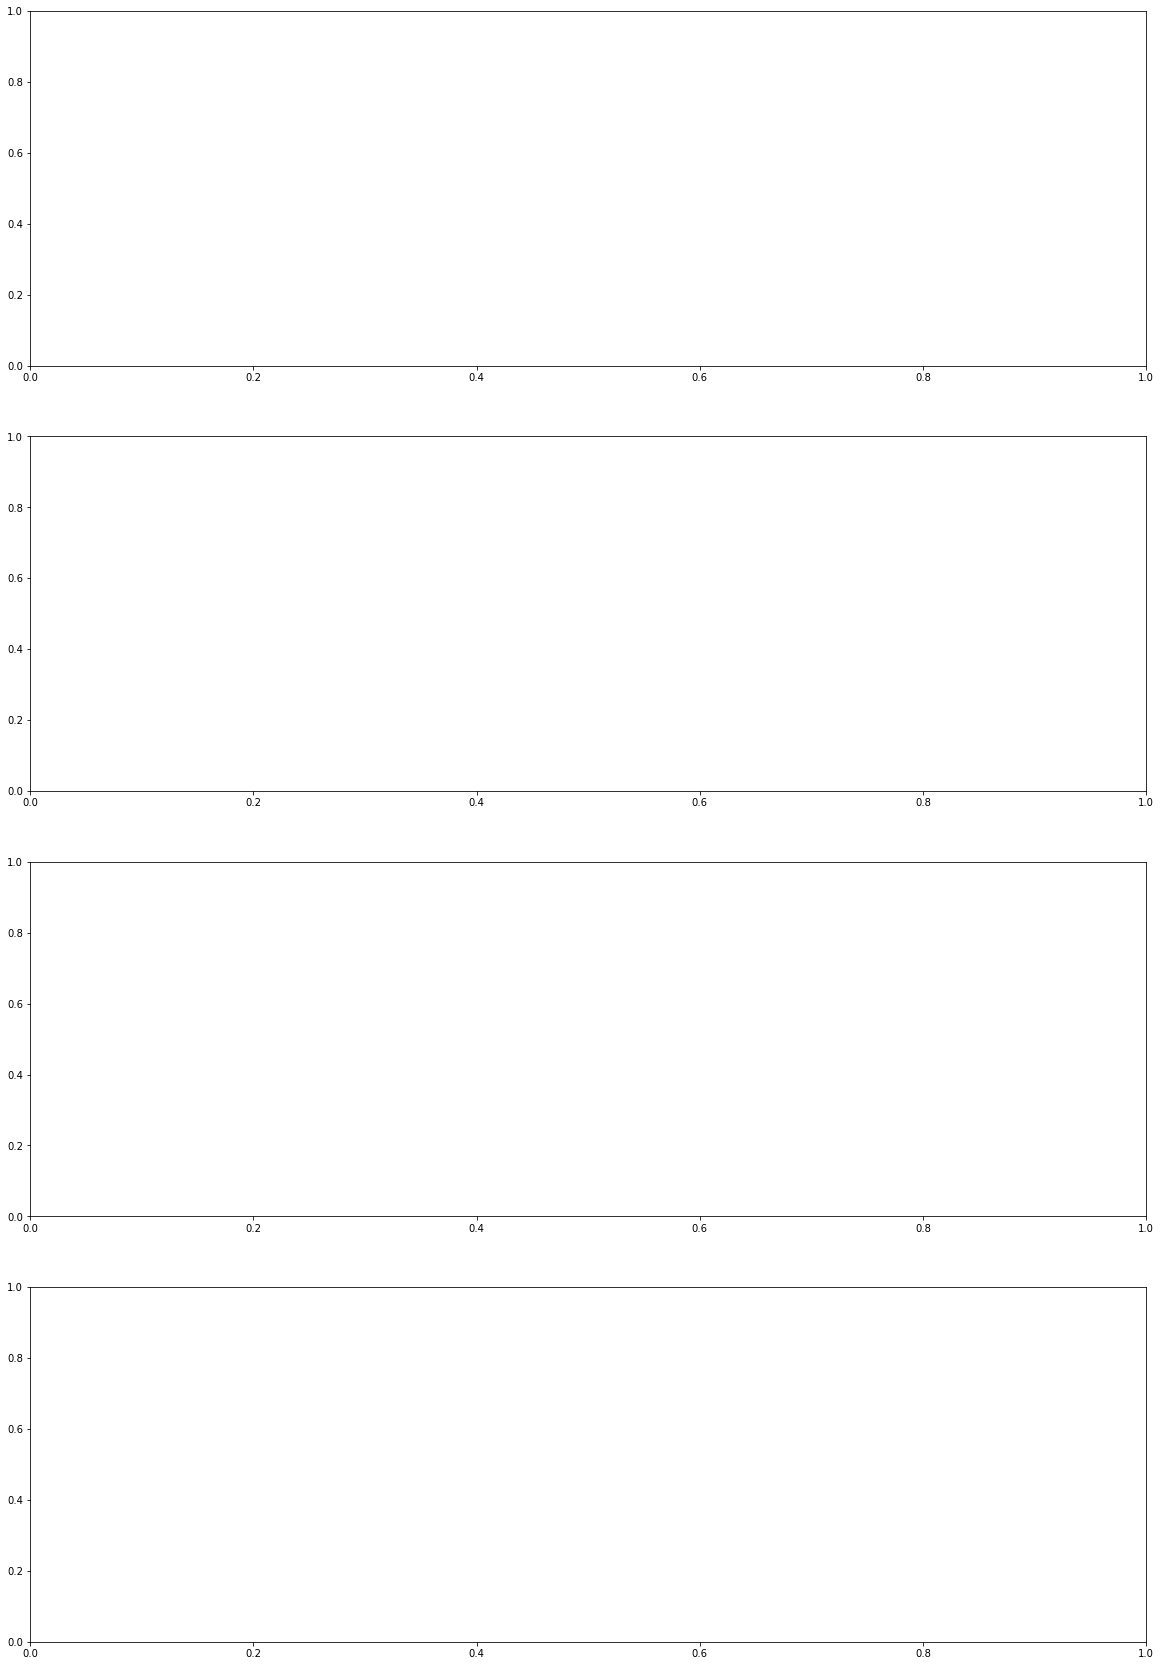

In [21]:
columns = EPSILONS
width = 0.21
n_alphas = len(PROBS)
ticks = np.arange(start=1, stop=len(columns)*2, step=2)
n_boxes = n_alphas + 1
disp = np.linspace(-width * (n_boxes-1) / 2, width * (n_boxes-1) / 2, n_boxes, endpoint=True)
positions = disp.reshape(-1, 1) + ticks
colors1 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
colors2 = ['tan', 'cyan', 'lightgreen', 'yellow', 'violet', 'orange', 'lightgray']

fig, ax = plt.subplots(nrows=4, figsize=(20, 30))
# Univariate ESS for \theta chain
bp1 = box_plot(ax[0], THETA_ESS_THUG.T.tolist(), 'red', 'tan', positions[0])
bps = []
for i in range(n_alphas):
    bps.append(box_plot(ax[0], THETA_ESS_THUG_AR[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
labels = ['THUG'] + ['THUG-AR $p$={}'.format(prob) for prob in PROBS]
ax[0].legend(
    handles, 
    labels, 
    loc='lower left')
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(columns)
ax[0].set_xlabel("$\\epsilon$", fontsize=20)
ax[0].set_ylabel("ESS $\\theta$", fontsize=20)
ax[0].semilogy()

# Univariate ESS for u chain
bp1 = box_plot(ax[1], U_ESS_THUG.T.tolist(), 'red', 'tan', positions[0])
bps = []
for i in range(n_alphas):
    bps.append(box_plot(ax[1], U_ESS_THUG_AR[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
labels = ['THUG'] + ['THUG-AR $p$={}'.format(prob) for prob in PROBS]
ax[1].legend(
    handles, 
    labels, 
    loc='lower left')
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(columns)
ax[1].set_xlabel("$\\epsilon$", fontsize=20)
ax[1].set_ylabel("ESS $u$", fontsize=20)
ax[1].semilogy()

# ACCEPTANCE PROBABILITY 
bp1_a = box_plot(ax[2], A_THUG.T.tolist(), 'red', 'tan', positions[0])
bps_a = []
for i in range(n_alphas):
    bps_a.append(box_plot(ax[2], A_THUG_AR[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_a["boxes"][0]] + [bp["boxes"][0] for bp in bps_a]
labels = ['THUG'] + ['THUG-AR $p$={}'.format(prob) for prob in PROBS]
ax[2].legend(
    handles, 
    labels, 
    loc='lower left')
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(columns)
ax[2].set_xlabel("$\\epsilon$", fontsize=20)
ax[2].set_ylabel("AP THUG/THUG-AR", fontsize=20)
ax[2].semilogy()

# #EJSD
# bp1_e = box_plot(ax[3], EJSD_HUG.T.tolist(), 'red', 'tan', positions[0])
# bps_e = []
# for i in range(len(ALPHAS)):
#     bps_e.append(box_plot(ax[3], EJSD_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
# handles = [bp1_e["boxes"][0]] + [bp["boxes"][0] for bp in bps_e]
# labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
# ax[3].legend(
#     handles, 
#     labels, 
#     loc='lower left')
# ax[3].set_xticks(ticks)
# ax[3].set_xticklabels(columns)
# ax[3].set_xlabel("$\\epsilon$", fontsize=20)
# ax[3].set_ylabel("EJSD", fontsize=20)
# ax[3].semilogy()

# # EJSD on Gradient Direction
# bp1_eg = box_plot(ax[4], G_EJSD_HUG.T.tolist(), 'red', 'tan', positions[0])
# bps_eg = []
# for i in range(len(ALPHAS)):
#     bps_eg.append(box_plot(ax[4], G_EJSD_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
# handles = [bp1_eg["boxes"][0]] + [bp["boxes"][0] for bp in bps_eg]
# labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
# ax[4].legend(
#     handles, 
#     labels, 
#     loc='lower left')
# ax[4].set_xticks(ticks)
# ax[4].set_xticklabels(columns)
# ax[4].set_xlabel("$\\epsilon$", fontsize=20)
# ax[4].set_ylabel("Gradient EJSD", fontsize=20)
# ax[4].semilogy()


# # EJSD on Tangent Direction
# bp1_et = box_plot(ax[5], T_EJSD_HUG.T.tolist(), 'red', 'tan', positions[0])
# bps_et = []
# for i in range(len(ALPHAS)):
#     bps_et.append(box_plot(ax[5], T_EJSD_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
# handles = [bp1_et["boxes"][0]] + [bp["boxes"][0] for bp in bps_et]
# labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
# ax[5].legend(
#     handles, 
#     labels, 
#     loc='lower left')
# ax[5].set_xticks(ticks)
# ax[5].set_xticklabels(columns)
# ax[5].set_xlabel("$\\epsilon$", fontsize=20)
# ax[5].set_ylabel("Tangent EJSD", fontsize=20)
# ax[5].semilogy()

# # Joint ESS for u chain
# bp1_jess = box_plot(ax[6], ESS_JOINT_HUG.T.tolist(), 'red', 'tan', positions[0])
# bps_jess = []
# for i in range(len(ALPHAS)):
#     bps_jess.append(box_plot(ax[6], ESS_JOINT_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
# handles = [bp1_jess["boxes"][0]] + [bp["boxes"][0] for bp in bps_jess]
# labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
# ax[6].legend(
#     handles, 
#     labels, 
#     loc='lower left')
# ax[6].set_xticks(ticks)
# ax[6].set_xticklabels(columns)
# ax[6].set_xlabel("$\\epsilon$", fontsize=20)
# ax[6].set_ylabel("ESS $\\xi$", fontsize=20)
# ax[6].semilogy()


# ax[0].set_title("Uniform Kernel, Uniform Prior of Parameters and Latents", fontsize=20)
plt.show()